In [ ]:
# Operator Learning via Kernel Methods
#
# This is mostly a script for prototyping methods

In [1]:
# Imports
import numpy as np
import sklearn as skl
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import pairwise_distances
import sys
sys.path.append('./')
from KLearn import *
from functools import reduce
import matplotlib.pyplot as plt

In [157]:
# Define some Kernels
gamma = 50;
K = lambda y1,y2 : rbf_kernel(y1,y2, gamma = gamma)
S = lambda x1,x2 : rbf_kernel(x1.T,x2.T, gamma = 0.00001) # lame, for now

In [158]:
### Generating Data

## GP kernel

def gp_kernel(t, sigma):
  return np.exp( - (1/(2*sigma**2))*t**2)

N_mesh = 100
x = np.linspace(0,1, N_mesh) # fine grid for visualization

## compute pairwise distance matrix

dist_matrix = pairwise_distances( x.reshape(-1,1), x.reshape(-1,1))

## GP lengthscale
sigma = 0.1
Cov_matrix = gp_kernel(dist_matrix, sigma) + 1e-8*np.eye(N_mesh)
Cov_matrix = 1/2*(Cov_matrix + Cov_matrix.T)

Cov_matrix_sqrt = np.linalg.cholesky(Cov_matrix)

In [166]:
## Training and test functions

N_train = 100    # Number of training functions
N_test  = 2     # Number of testing functions
u_train = np.zeros((N_mesh, N_train))
u_test  = np.zeros((N_mesh, N_test))

for i in range(N_train):
  xi = np.random.randn(N_mesh)
  u_train[:, i] = np.dot(Cov_matrix_sqrt, xi)

for i in range(N_test):
  xi = np.random.randn(N_mesh)
  u_test [:, i] = np.dot(Cov_matrix_sqrt, xi)

# define pointwise operator

def op_square(u):
  return u**2

def op_sin(u):
    return np.sin(u)

def op_I(u):
    return u

v_train = op_I(u_train)
v_test  = op_I(u_test)

In [167]:
# Finish setting up
U = u_train;
V = v_train;
Y = x.reshape((-1, 1));

print(np.shape(U))
print(np.shape(V))
print(np.shape(Y))

(100, 100)
(100, 100)
(100, 1)


In [168]:
# LEARN!
D = KLearn(U,V,N_mesh,S,K,Y)

In [169]:
# Does it work... ?
v_mod = D(u_test);
np.max(np.abs(v_mod(Y) - v_test)) # very nice...

0.0024025314583715485

[Text(0.5, 0, 'x'), Text(0, 0.5, 'v_i(x)')]

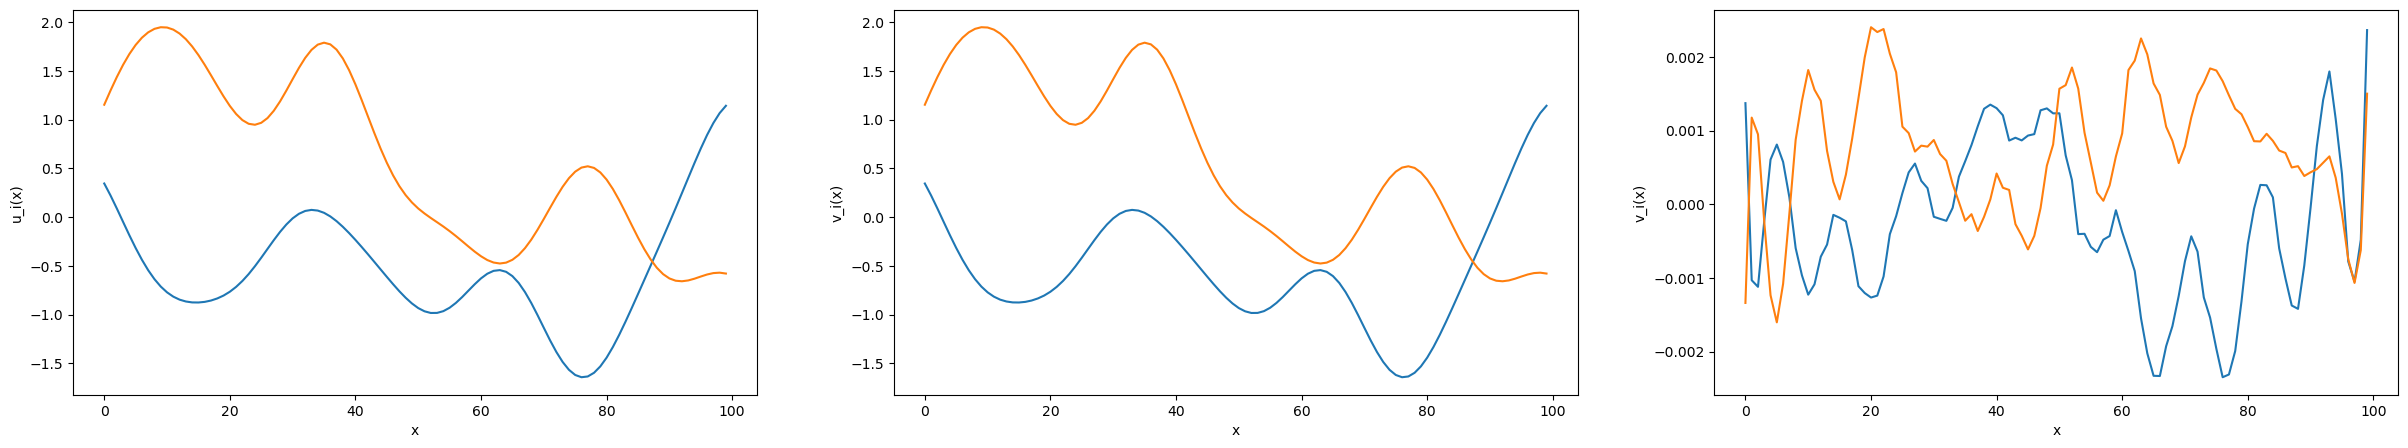

In [170]:
fig, ax = plt.subplots(1,3)

fig.set_size_inches(30,5)

ax[0].plot(u_test)
ax[0].set( xlabel ='x', ylabel='u_i(x)' )

ax[1].plot(v_test)
ax[1].set( xlabel ='x', ylabel='v_i(x)' )

ax[2].plot(v_mod(Y)-v_test)
ax[2].set( xlabel ='x', ylabel='v_i(x)' )


#ax[0].plot(u_train)
#ax[0].set( xlabel ='x', ylabel='u_i(x)' )

#ax[1].plot(v_train)
#ax[1].set( xlabel ='x', ylabel='v_i(x)' )

#ax[2].plot(u_test)
#ax[2].set( xlabel ='x', ylabel='u_i(x)' )

#ax[3].plot(v_test)
#ax[3].set( xlabel ='x', ylabel='v_i(x)' )

In [171]:
plt.figure(figsize = (10,5)) # set the size of the figure
plt.plot(Y,f1(ypsi), label="f3") # scatter plot of the data
plt.scatter(ypsi,f1(ypsi), label="f3") # scatter plot of the data
plt.plot(ypsi,fsin1(ypsi), label="fs3")
plt.scatter(ypsi,fSin1(ypsi), label = "fS3")
plt.legend(loc="upper left")
plt.xlabel('x')  # x-axis label
plt.grid()
# plt.savefig('OpL_plot.png', dpi = 600, bbox_inches = 'tight')

NameError: name 'f1' is not defined

<Figure size 1000x500 with 0 Axes>